**Introduction**

 In this script, we evaluate aspects of reliability, validity and fairness. In the first exercise, we model the data with a regression model, whereas we model the data with a classification model in the second exercise. To run it, it is sufficient to press the "play" button in each cell. We start with importing the packages and loading the data from a Google Drive Folder:

In [ ]:
import os

os.environ["PYTHONHASHSEED"] = str(42)

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
!wget -O training_set_rel3.tsv 'https://drive.google.com/uc?export=download&id=1ptegxIM5hB6fZNTqXg7xachk-Ax9dGdY'

--2025-01-28 10:40:15--  https://drive.google.com/uc?export=download&id=1ptegxIM5hB6fZNTqXg7xachk-Ax9dGdY
Resolving drive.google.com (drive.google.com)... 142.251.2.138, 142.251.2.113, 142.251.2.101, ...
Connecting to drive.google.com (drive.google.com)|142.251.2.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1ptegxIM5hB6fZNTqXg7xachk-Ax9dGdY&export=download [following]
--2025-01-28 10:40:16--  https://drive.usercontent.google.com/download?id=1ptegxIM5hB6fZNTqXg7xachk-Ax9dGdY&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.137.132, 2607:f8b0:4023:c03::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.137.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16337165 (16M) [application/octet-stream]
Saving to: ‘training_set_rel3.tsv’

training_set_rel3.t 100%[===================>]  15.58M  20.6M

In [ ]:
file_path = 'training_set_rel3.tsv'
columns = ['essay_id', 'essay_set', 'essay', 'domain1_score', 'rater1_domain1', 'rater2_domain1']
asap = pd.read_csv(file_path, sep='\t', encoding='ISO-8859-1', usecols=columns)

The following code prints the file:

In [ ]:
print(asap)

       essay_id  essay_set                                              essay  \
0             1          1  Dear local newspaper, I think effects computer...   
1             2          1  Dear @CAPS1 @CAPS2, I believe that using compu...   
2             3          1  Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...   
3             4          1  Dear Local Newspaper, @CAPS1 I have found that...   
4             5          1  Dear @LOCATION1, I know having computers has a...   
...         ...        ...                                                ...   
12971     21626          8   In most stories mothers and daughters are eit...   
12972     21628          8   I never understood the meaning laughter is th...   
12973     21629          8  When you laugh, is @CAPS5 out of habit, or is ...   
12974     21630          8                                 Trippin' on fen...   
12975     21633          8   Many people believe that laughter can improve...   

       rater1_domain1  rate

Initially, the scores have different ranges for each set. To start our analysis, we first normalize the test scores in the following code to a range from 0 to 1:

In [ ]:
sets = asap['essay_set'].unique()
scores = pd.DataFrame(asap, columns=['essay_set', 'domain1_score'])
scores_grp = scores.groupby(['essay_set'], as_index=False)
essay = pd.DataFrame(sets, columns=['sets'])
essay['counts'] = scores_grp.count()['domain1_score']
essay['min'] = scores_grp.min()['domain1_score']
essay['max'] = scores_grp.max()['domain1_score']
essay['med'] = scores_grp.median()['domain1_score']
print(essay)

   sets  counts  min  max   med
0     1    1783    2   12   8.0
1     2    1800    1    6   3.0
2     3    1726    0    3   2.0
3     4    1770    0    3   1.0
4     5    1805    0    4   2.0
5     6    1800    0    4   3.0
6     7    1569    2   24  16.0
7     8     723   10   60  37.0


In [ ]:
scores = {}

for es in sets:
    min_es = asap[asap['essay_set'] == es].domain1_score.min()
    max_es =  asap[asap['essay_set'] == es].domain1_score.max()
    scores[es] = (min_es, max_es)
scores

{1: (2, 12),
 2: (1, 6),
 3: (0, 3),
 4: (0, 3),
 5: (0, 4),
 6: (0, 4),
 7: (2, 24),
 8: (10, 60)}

In [ ]:
def minmax_scaler(es, score):
    return (score - scores[es][0]) / (scores[es][1] - scores[es][0])

def inverse_scaler(es, score):
    return round(score * (scores[es][1] - scores[es][0]) + scores[es][0])

In [ ]:
def scale_dataset(asap):
    for row in range(len(asap)):
        asap.loc[row, 'nscore'] = minmax_scaler(asap.loc[row, 'essay_set'], asap.loc[row, 'domain1_score'])
    return asap

In [ ]:
asap = scale_dataset(asap)

The following line of code prints the normalized score as a new column nscore.

In [ ]:
print(asap)

       essay_id  essay_set                                              essay  \
0             1          1  Dear local newspaper, I think effects computer...   
1             2          1  Dear @CAPS1 @CAPS2, I believe that using compu...   
2             3          1  Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...   
3             4          1  Dear Local Newspaper, @CAPS1 I have found that...   
4             5          1  Dear @LOCATION1, I know having computers has a...   
...         ...        ...                                                ...   
12971     21626          8   In most stories mothers and daughters are eit...   
12972     21628          8   I never understood the meaning laughter is th...   
12973     21629          8  When you laugh, is @CAPS5 out of habit, or is ...   
12974     21630          8                                 Trippin' on fen...   
12975     21633          8   Many people believe that laughter can improve...   

       rater1_domain1  rate

We are now prepared to start with our analysis.

**Setting up the Treatment as Classification Problem**

To treat the model as a classification problem, we further define two classes based on the nscore. For simplicity, we define nscores below 0.5 as class 0, and nscores equal to or larger than 0.5 as class 1.

In [ ]:
asap['nclass'] = np.round(asap['nscore'])
asap['nclass'] = asap['nclass'].astype(int)

The new classes are given as a new variable nclass.

In [ ]:
print(asap)

       essay_id  essay_set                                              essay  \
0             1          1  Dear local newspaper, I think effects computer...   
1             2          1  Dear @CAPS1 @CAPS2, I believe that using compu...   
2             3          1  Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...   
3             4          1  Dear Local Newspaper, @CAPS1 I have found that...   
4             5          1  Dear @LOCATION1, I know having computers has a...   
...         ...        ...                                                ...   
12971     21626          8   In most stories mothers and daughters are eit...   
12972     21628          8   I never understood the meaning laughter is th...   
12973     21629          8  When you laugh, is @CAPS5 out of habit, or is ...   
12974     21630          8                                 Trippin' on fen...   
12975     21633          8   Many people believe that laughter can improve...   

       rater1_domain1  rate

**Essay Scoring as a Regression Model**

We start with the discussion of the regression problem. As a first approach, we define a pre-trained transformer model (Huggingface's DistilBERT) to predict nscore from the essays. We start with installing and loading the necessary packages.

In [ ]:
!pip install accelerate
!pip install datasets
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 21.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import datasets
from datasets import load_dataset
import transformers
import accelerate
import random
import torch
from transformers import set_seed

To unify our results as much as possible, we first set a seed.

In [ ]:
def set_gen_seed(seed):
    set_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_gen_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

We transform asap into a dataset in the format of  Huggingface's datasets and further define training (train_df), validation (val_df) and test (test_df) sets.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

def split_data_by_group(df, group_var, train_frac=0.6, test_frac=0.2, random_state=42):
    """
    Splits a DataFrame into training, validation, and test sets, with splits performed within each level of the specified group variable.

    Parameters:
    - df: pandas DataFrame to split.
    - group_var: String name of the column containing group identifiers.
    - train_frac: Fraction of the data to allocate to the training set.
    - test_frac: Fraction of the data to allocate to the test set. The remainder goes to the validation set.
    - random_state: Random state for reproducibility.

    Returns:
    - train_df: Training data DataFrame.
    - val_df: Validation data DataFrame.
    - test_df: Test data DataFrame.
    """
    train_df = pd.DataFrame()
    val_df = pd.DataFrame()
    test_df = pd.DataFrame()

    for _, group_df in df.groupby(group_var):
        # Split current group into training and temp (validation + test) sets
        train, temp = train_test_split(group_df, train_size=train_frac, random_state=random_state)

        # Split temp into validation and test sets
        validation, test = train_test_split(temp, test_size=test_frac/(1 - train_frac), random_state=random_state)

        # Append current group's splits to the overall datasets
        train_df = pd.concat([train_df, train])
        val_df = pd.concat([val_df, validation])
        test_df = pd.concat([test_df, test])

    return train_df, val_df, test_df

We further rename nscore as labels. This is necessary so that the score is handled correctly by Huggingface's transformer models:

In [ ]:
asap['labels'] = asap['nscore']

In [ ]:
train_df, valid_df, test_df = split_data_by_group(asap[['essay','essay_set','labels', 'rater1_domain1', 'rater2_domain1']], asap['essay_set'], train_frac=0.6, test_frac=0.2, random_state=42)

In [ ]:
print(train_df)

                                                   essay  essay_set  labels  \
1661   Dear @LOCATION1 press, I have recently heard a...          1    0.70   
1525   To: @ORGANIZATION1 goes so fast, and the most ...          1    0.60   
881    Dear local newspaper, I've heard that you were...          1    0.60   
1468   Dear local news paper, This paper is going to ...          1    0.40   
730    Honestly, I totally and absolutely believe tha...          1    0.60   
...                                                  ...        ...     ...   
12324   There are a couple things that can lead stran...          8    0.50   
12359   In a relationship you should be able to trust...          8    0.68   
12523   Laughter is a huge part oh building friendshi...          8    0.50   
12688   I think that laughter is a key element to any...          8    0.60   
12355   I'm a tell you about moments sometimes even a...          8    0.40   

       rater1_domain1  rater2_domain1  
1661       

We tokenize all data sets using the DistilBERT model:

In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt, model_max_length=512)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def tokenize(batch):
  return tokenizer(batch["essay"], truncation = True, padding='max_length', max_length=512)

In [ ]:
from datasets import Dataset

train_ds = Dataset.from_pandas(train_df)
valid_ds = Dataset.from_pandas(valid_df)
test_ds = Dataset.from_pandas(test_df)

In [ ]:
train_encoded = train_ds.map(tokenize, batched = True, batch_size= None)
valid_encoded = valid_ds.map(tokenize, batched = True, batch_size= None)
test_encoded = test_ds.map(tokenize, batched = True, batch_size= None)

Map:   0%|          | 0/7783 [00:00<?, ? examples/s]

Map:   0%|          | 0/2596 [00:00<?, ? examples/s]

Map:   0%|          | 0/2597 [00:00<?, ? examples/s]

In regression models, the number of predicted classes (num_labels) is set to 1 in Huggingface.

In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = 1
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels = num_labels)).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 8
logging_steps = len(train_encoded)// batch_size
model_name = "finetuned-dataset"
training_args = TrainingArguments(output_dir = model_name,
                                  num_train_epochs=3,
                                  learning_rate = 2e-5,
                                  weight_decay = 0.01,
                                  evaluation_strategy="epoch",
                                  report_to="none",
                                  logging_steps = logging_steps)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


To obtain suitable metrics, we further import and define the mean squared error for the regression problem.

In [ ]:
from sklearn.metrics import root_mean_squared_error

def compute_metrics(pred):
    predictions, labels = pred
    rmse = root_mean_squared_error(labels, predictions)
    return {"rmse": rmse}

In [ ]:
trainer = Trainer(model = model, args = training_args,
                  compute_metrics = compute_metrics,
                  train_dataset = train_encoded,
                  eval_dataset = valid_encoded,
                  tokenizer = tokenizer)
trainer.train()

<ipython-input-29-3f27baba4475>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model = model, args = training_args,


Epoch,Training Loss,Validation Loss,Rmse
1,0.027700,0.020268,0.142367
2,0.017100,0.020234,0.142246
3,0.012700,0.019506,0.139664


TrainOutput(global_step=2919, training_loss=0.019196790925400352, metrics={'train_runtime': 574.5859, 'train_samples_per_second': 40.636, 'train_steps_per_second': 5.08, 'total_flos': 3092926132288512.0, 'train_loss': 0.019196790925400352, 'epoch': 3.0})

We save the regression model:

In [ ]:
model.save_pretrained("finetuned-regression-model")

**Split-half Reliability in Regression Models**

We split the text in two halves and compare the predictions for each half.

In [ ]:
import pandas as pd
import re

# Function to split sentences into halves
def split_sentences_to_halves(text):
    # Remove starting and ending ''
    text = text.strip("''")

    # Split into sentences using regex
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)

    midpoint = len(sentences) // 2

    first_half = " ".join(sentences[:midpoint])
    second_half = " ".join(sentences[midpoint:])

    return first_half, second_half

Application to our data:

In [ ]:
train_rel = train_df.copy()
valid_rel = valid_df.copy()
test_rel = test_df.copy()

In [ ]:
train_rel[['first_half', 'second_half']] = train_rel['essay'].apply(split_sentences_to_halves).apply(pd.Series)
valid_rel[['first_half', 'second_half']] = valid_rel['essay'].apply(split_sentences_to_halves).apply(pd.Series)
test_rel[['first_half', 'second_half']] = test_rel['essay'].apply(split_sentences_to_halves).apply(pd.Series)

In [ ]:
train_rel_a = train_rel.copy()
valid_rel_a = valid_rel.copy()
test_rel_a = test_rel.copy()

train_rel_a = train_rel_a.drop(columns=['essay', 'second_half'])
train_rel_a = train_rel_a.rename(columns={'first_half': 'essay'})

valid_rel_a = valid_rel_a.drop(columns=['essay', 'second_half'])
valid_rel_a = valid_rel_a.rename(columns={'first_half': 'essay'})

test_rel_a = test_rel_a.drop(columns=['essay', 'second_half'])
test_rel_a = test_rel_a.rename(columns={'first_half': 'essay'})

In [ ]:
train_rel_b = train_rel.copy()
valid_rel_b = valid_rel.copy()
test_rel_b = test_rel.copy()

train_rel_b = train_rel_b.drop(columns=['essay', 'first_half'])
train_rel_b = train_rel_b.rename(columns={'second_half': 'essay'})

valid_rel_b = valid_rel_b.drop(columns=['essay', 'first_half'])
valid_rel_b = valid_rel_b.rename(columns={'second_half': 'essay'})

test_rel_b = test_rel_b.drop(columns=['essay', 'first_half'])
test_rel_b = test_rel_b.rename(columns={'second_half': 'essay'})

In [ ]:
train_rel2_a = Dataset.from_pandas(train_rel_a)
valid_rel2_a = Dataset.from_pandas(valid_rel_a)
test_rel2_a = Dataset.from_pandas(test_rel_a)

train_rel2_b = Dataset.from_pandas(train_rel_b)
valid_rel2_b = Dataset.from_pandas(valid_rel_b)
test_rel2_b = Dataset.from_pandas(test_rel_b)

We encode the texts:

In [ ]:
train_encoded2_a = train_rel2_a.map(tokenize, batched = True, batch_size= None)
valid_encoded2_a = valid_rel2_a.map(tokenize, batched = True, batch_size= None)
test_encoded2_a = test_rel2_a.map(tokenize, batched = True, batch_size= None)

train_encoded2_b = train_rel2_b.map(tokenize, batched = True, batch_size= None)
valid_encoded2_b = valid_rel2_b.map(tokenize, batched = True, batch_size= None)
test_encoded2_b = test_rel2_b.map(tokenize, batched = True, batch_size= None)

Map:   0%|          | 0/7783 [00:00<?, ? examples/s]

Map:   0%|          | 0/2596 [00:00<?, ? examples/s]

Map:   0%|          | 0/2597 [00:00<?, ? examples/s]

Map:   0%|          | 0/7783 [00:00<?, ? examples/s]

Map:   0%|          | 0/2596 [00:00<?, ? examples/s]

Map:   0%|          | 0/2597 [00:00<?, ? examples/s]

We get the predictions for each half of the training, validation and test data set.

In [ ]:
import numpy as np

training_predictions_a = trainer.predict(train_encoded2_a)

training_predictions_b = trainer.predict(train_encoded2_b)

In [ ]:
validation_predictions_a = trainer.predict(valid_encoded2_a)

validation_predictions_b = trainer.predict(valid_encoded2_b)

In [ ]:
test_predictions_a = trainer.predict(test_encoded2_a)

test_predictions_b = trainer.predict(test_encoded2_b)

We plot three scatter plots and calculate the correlations between the predictions. We start with the validation data:

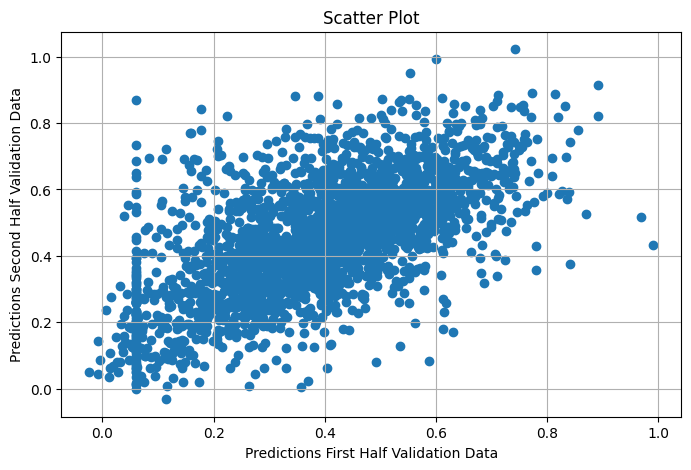

In [ ]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(8, 5))  # Set the figure size
plt.scatter(validation_predictions_a[0], validation_predictions_b[0])  # Create a scatter plot
plt.title("Scatter Plot")  # Title of the plot
plt.xlabel("Predictions First Half Validation Data")  # X-axis label
plt.ylabel("Predictions Second Half Validation Data")  # Y-axis label
plt.grid(True)  # Show grid
plt.show()

In [ ]:
from scipy.stats import pearsonr

correlation, p_value = pearsonr(validation_predictions_a[0].flatten(), validation_predictions_b[0].flatten())

print(correlation)

0.6385786027398994


The corresponding analysis for the training data:

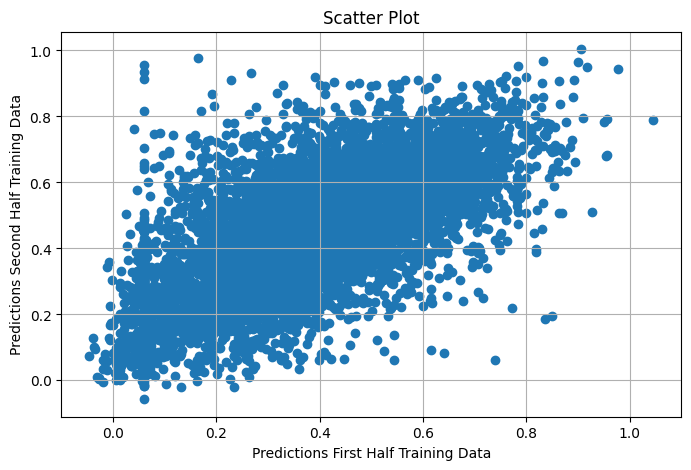

In [ ]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(8, 5))  # Set the figure size
plt.scatter(training_predictions_a[0], training_predictions_b[0])  # Create a scatter plot
plt.title("Scatter Plot")  # Title of the plot
plt.xlabel("Predictions First Half Training Data")  # X-axis label
plt.ylabel("Predictions Second Half Training Data")  # Y-axis label
plt.grid(True)  # Show grid
plt.show()

In [ ]:
from scipy.stats import pearsonr

correlation, p_value = pearsonr(training_predictions_a[0].flatten(), training_predictions_b[0].flatten())

print(correlation)

0.6706151544147118


And the test data:

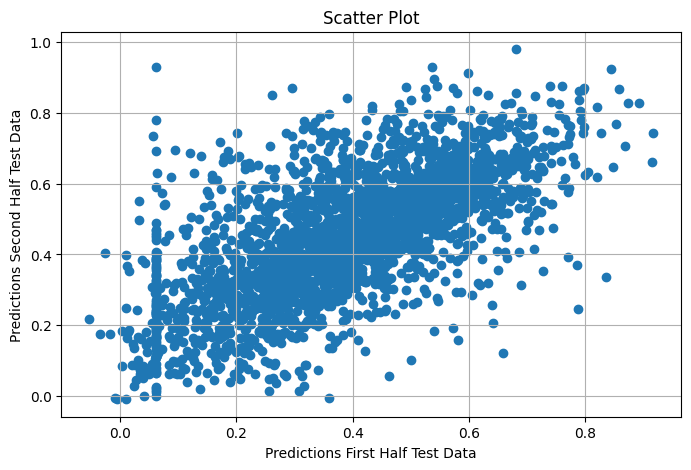

In [ ]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(8, 5))  # Set the figure size
plt.scatter(test_predictions_a[0], test_predictions_b[0])  # Create a scatter plot
plt.title("Scatter Plot")  # Title of the plot
plt.xlabel("Predictions First Half Test Data")  # X-axis label
plt.ylabel("Predictions Second Half Test Data")  # Y-axis label
plt.grid(True)  # Show grid
plt.show()

In [ ]:
from scipy.stats import pearsonr

correlation, p_value = pearsonr(test_predictions_a[0].flatten(), test_predictions_b[0].flatten())

print(correlation)

0.6677013147034663


**Validity in Regression Models: Evaluating the Effect of Inserting Random Letters**

We insert 10 random letters and inspect the changes.

In [ ]:
import pandas as pd
import random
import string

def introduce_typos(text, num_typos=10):
    # Remove starting and ending ''
    text = text.strip("''")

    # Create a list of possible insertion points
    insertion_points = [i for i in range(len(text)) if text[i] != ' ']

    # Randomly select insertion points
    selected_points = random.sample(insertion_points, min(num_typos, len(insertion_points)))

    # Insert random letters at those points
    for point in selected_points:
        random_letter = random.choice(string.ascii_lowercase)
        text = text[:point] + random_letter + text[point:]

    return "''" + text + "''"  # Re-add ''

We apply this function to our essays:

In [ ]:
train_typo = train_df.copy()
valid_typo = valid_df.copy()
test_typo = test_df.copy()

In [ ]:
train_typo['essay_error'] = train_typo['essay'].apply(introduce_typos)
valid_typo['essay_error'] = valid_typo['essay'].apply(introduce_typos)
test_typo['essay_error'] = test_typo['essay'].apply(introduce_typos)

In [ ]:
train_typo = train_typo.drop(columns=['essay'])
train_typo = train_typo.rename(columns={'essay_error': 'essay'})

valid_typo = valid_typo.drop(columns=['essay'])
valid_typo = valid_typo.rename(columns={'essay_error': 'essay'})

test_typo = test_typo.drop(columns=['essay'])
test_typo = test_typo.rename(columns={'essay_error': 'essay'})

In [ ]:
train_val_2 = Dataset.from_pandas(train_df)
train_typo_2 = Dataset.from_pandas(train_typo)

valid_val_2 = Dataset.from_pandas(valid_df)
valid_typo_2 = Dataset.from_pandas(valid_typo)

test_val_2 = Dataset.from_pandas(test_df)
test_typo_2 = Dataset.from_pandas(test_typo)

We encode the texts:

In [ ]:
train_val_encoded2 = train_val_2.map(tokenize, batched = True, batch_size= None)
train_typo_encoded2 = train_typo_2.map(tokenize, batched = True, batch_size= None)

valid_val_encoded2 = valid_val_2.map(tokenize, batched = True, batch_size= None)
valid_typo_encoded2 = valid_typo_2.map(tokenize, batched = True, batch_size= None)

test_val_encoded2 = test_val_2.map(tokenize, batched = True, batch_size= None)
test_typo_encoded2 = test_typo_2.map(tokenize, batched = True, batch_size= None)

Map:   0%|          | 0/7783 [00:00<?, ? examples/s]

Map:   0%|          | 0/7783 [00:00<?, ? examples/s]

Map:   0%|          | 0/2596 [00:00<?, ? examples/s]

Map:   0%|          | 0/2596 [00:00<?, ? examples/s]

Map:   0%|          | 0/2597 [00:00<?, ? examples/s]

Map:   0%|          | 0/2597 [00:00<?, ? examples/s]

We get the predictions and compare them for the training data:

In [ ]:
import numpy as np

orig_predictions_train = trainer.predict(train_val_encoded2)

typo_predictions_train = trainer.predict(train_typo_encoded2)

... the validation data...

In [ ]:
import numpy as np
from scipy.special import softmax

orig_predictions_valid = trainer.predict(valid_val_encoded2)

typo_predictions_valid = trainer.predict(valid_typo_encoded2)

... and the test data:

In [ ]:
import numpy as np
from scipy.special import softmax

orig_predictions_test = trainer.predict(test_val_encoded2)

typo_predictions_test = trainer.predict(test_typo_encoded2)

Again, we plot scatter plots and calculate correlations:

Training Data:

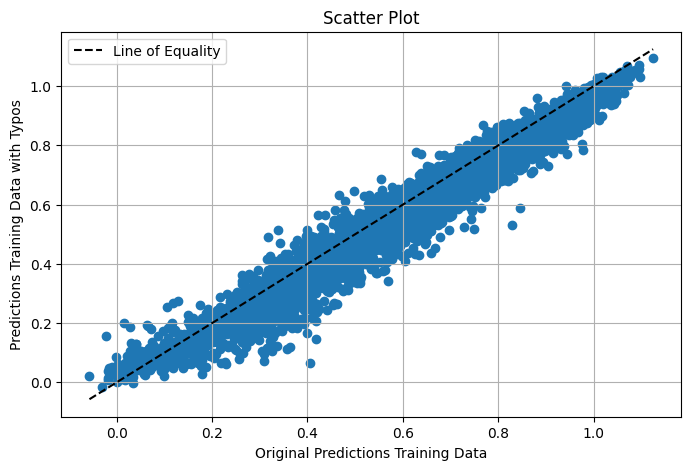

In [ ]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(8, 5))  # Set the figure size
plt.scatter(orig_predictions_train[0], typo_predictions_train[0])  # Create a scatter plot

# Add the line of equality
# We need to determine the range to cover all points comfortably
min_val = min(min(orig_predictions_train[0]), min(typo_predictions_train[0]))
max_val = max(max(orig_predictions_train[0]), max(typo_predictions_train[0]))
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='Line of Equality')  # Plot the line of equality

# Add labels and title
plt.title("Scatter Plot")  # Title of the plot
plt.xlabel("Original Predictions Training Data")  # X-axis label
plt.ylabel("Predictions Training Data with Typos")  # Y-axis label
plt.grid(True)  # Show grid
plt.legend()  # Show legend
plt.show()  # Display the plot

In [ ]:
from scipy.stats import pearsonr

correlation, p_value = pearsonr(orig_predictions_train[0].flatten(), typo_predictions_train[0].flatten())

print(correlation)

0.979922956512615


Validation Data:

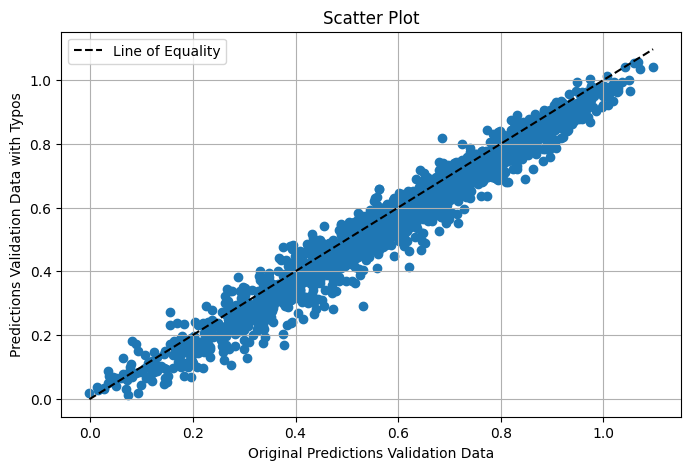

In [ ]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(8, 5))  # Set the figure size
plt.scatter(orig_predictions_valid[0], typo_predictions_valid[0])  # Create a scatter plot

# Add the line of equality
# We need to determine the range to cover all points comfortably
min_val = min(min(orig_predictions_valid[0]), min(typo_predictions_valid[0]))
max_val = max(max(orig_predictions_valid[0]), max(typo_predictions_valid[0]))
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='Line of Equality')  # Plot the line of equality

# Add labels and title
plt.title("Scatter Plot")  # Title of the plot
plt.xlabel("Original Predictions Validation Data")  # X-axis label
plt.ylabel("Predictions Validation Data with Typos")  # Y-axis label
plt.grid(True)  # Show grid
plt.legend()  # Show legend
plt.show()  # Display the plot

In [ ]:
from scipy.stats import pearsonr

correlation, p_value = pearsonr(orig_predictions_valid[0].flatten(), typo_predictions_valid[0].flatten())

print(correlation)

0.9814985189380274


Test data:

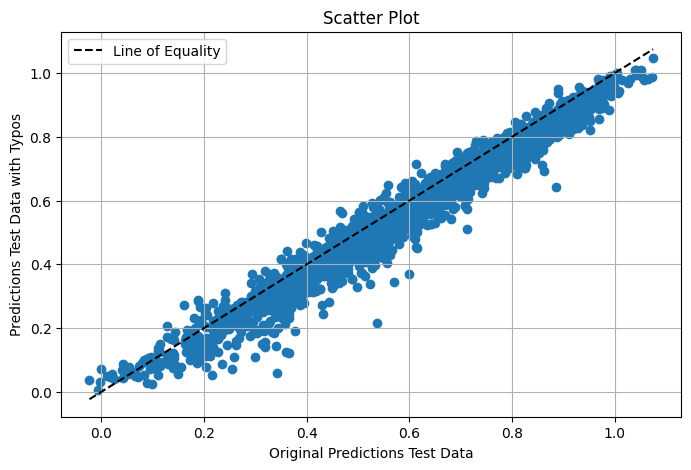

In [ ]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(8, 5))  # Set the figure size
plt.scatter(orig_predictions_test[0], typo_predictions_test[0])  # Create a scatter plot

# Add the line of equality
# We need to determine the range to cover all points comfortably
min_val = min(min(orig_predictions_test[0]), min(typo_predictions_test[0]))
max_val = max(max(orig_predictions_test[0]), max(typo_predictions_test[0]))
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='Line of Equality')  # Plot the line of equality

# Add labels and title
plt.title("Scatter Plot")  # Title of the plot
plt.xlabel("Original Predictions Test Data")  # X-axis label
plt.ylabel("Predictions Test Data with Typos")  # Y-axis label
plt.grid(True)  # Show grid
plt.legend()  # Show legend
plt.show()  # Display the plot

In [ ]:
from scipy.stats import pearsonr

correlation, p_value = pearsonr(orig_predictions_test[0].flatten(), typo_predictions_test[0].flatten())

print(correlation)

0.9821010410821585


**Fairness Evaluation in Regression Models: The Accuracy is Comparable over all topics**

We first get the predictions per essay for the validation set:

In [ ]:
validation_predictions = trainer.predict(valid_encoded)

 The training set:

In [ ]:
training_predictions = trainer.predict(train_encoded)

And the test set:

In [ ]:
test_predictions = trainer.predict(test_encoded)

Merging predictions and true values for each essay set:

In [ ]:
y_train_true = np.array(train_encoded["labels"])
y_train_set = np.array(train_encoded["essay_set"])
y_train_pred = training_predictions[0]

y_valid_true = np.array(valid_encoded["labels"])
y_valid_set = np.array(valid_encoded["essay_set"])
y_valid_pred = validation_predictions[0]

y_test_true = np.array(test_encoded["labels"])
y_test_set = np.array(test_encoded["essay_set"])
y_test_pred = test_predictions[0]

In [ ]:
y_train = np.column_stack((y_train_set, y_train_true, y_train_pred))
y_valid = np.column_stack((y_valid_set, y_valid_true, y_valid_pred))
y_test = np.column_stack((y_test_set, y_test_true, y_test_pred))

Training data:

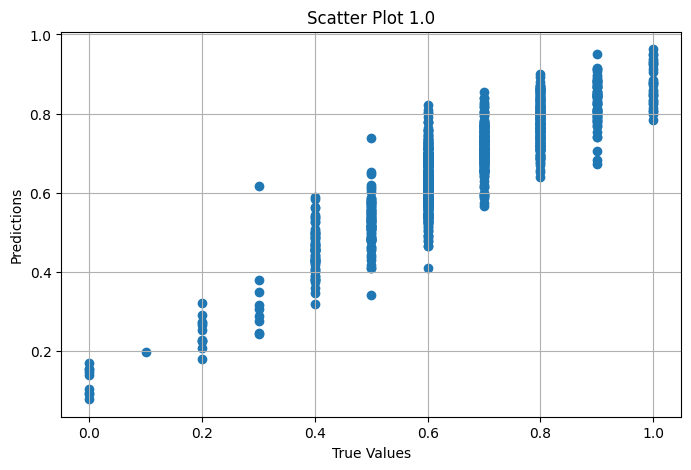

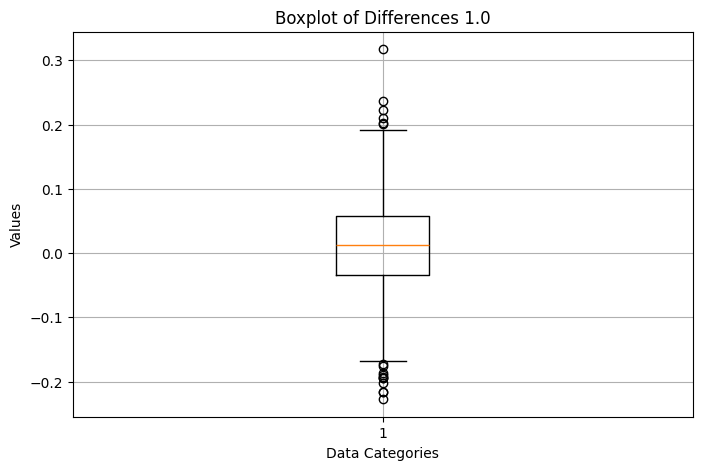

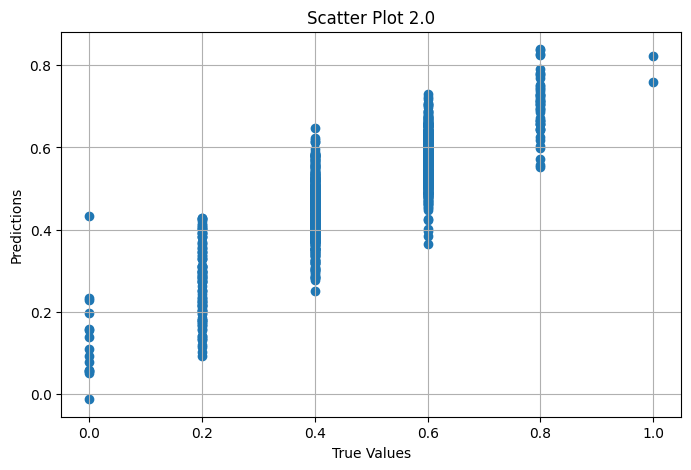

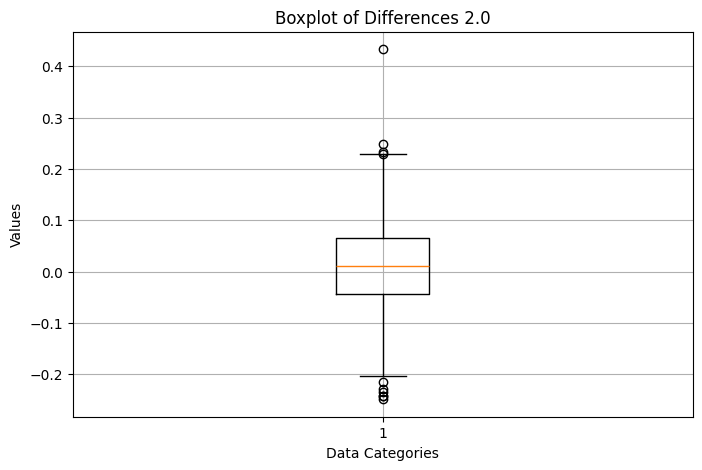

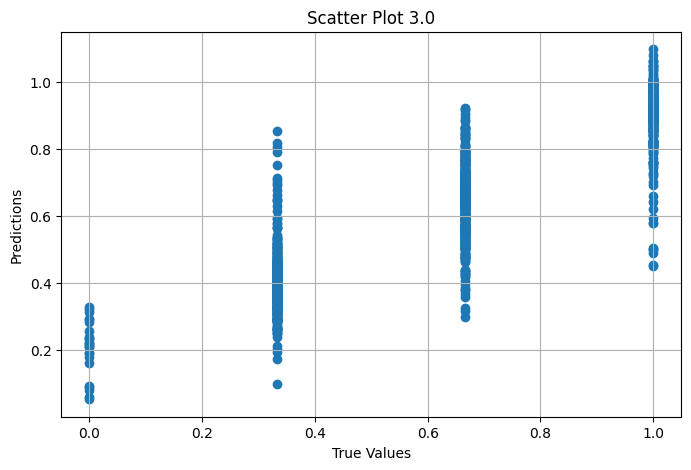

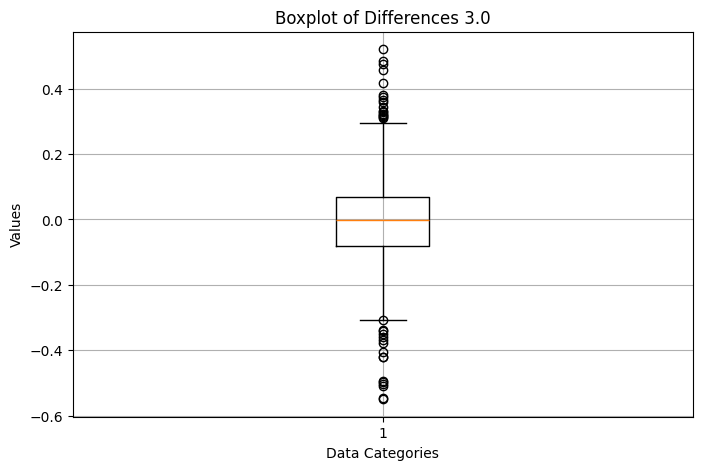

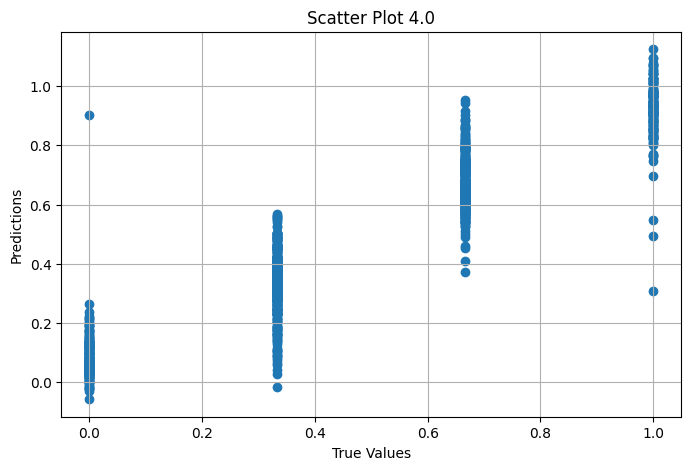

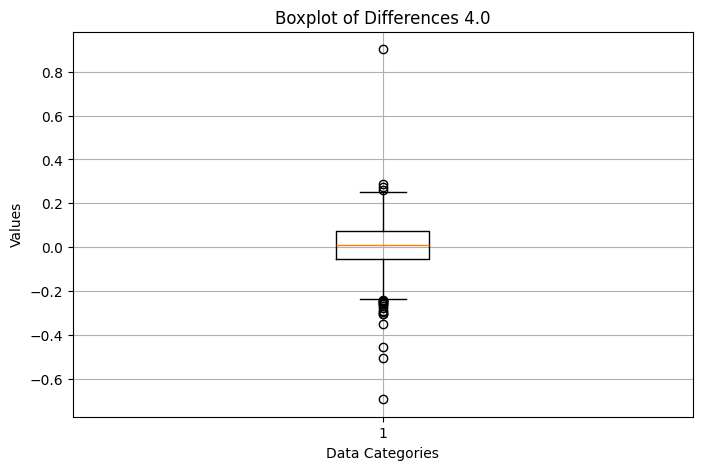

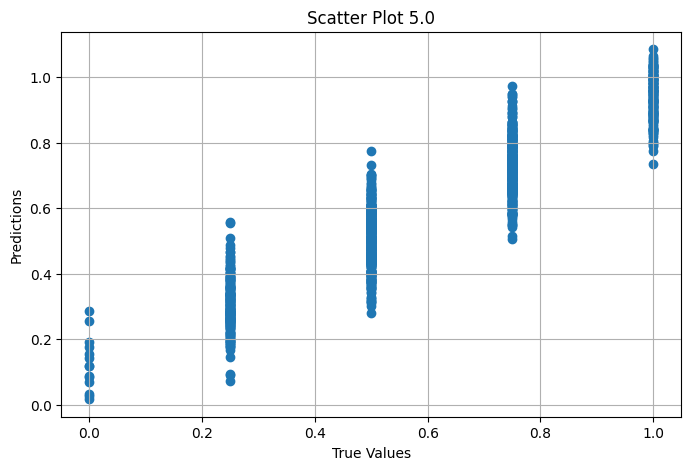

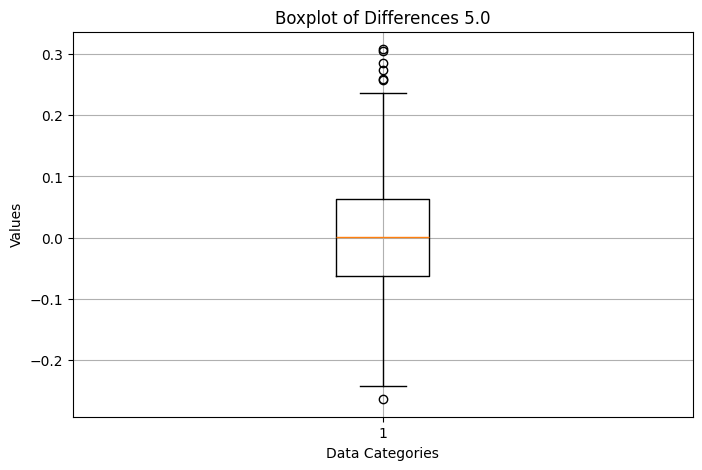

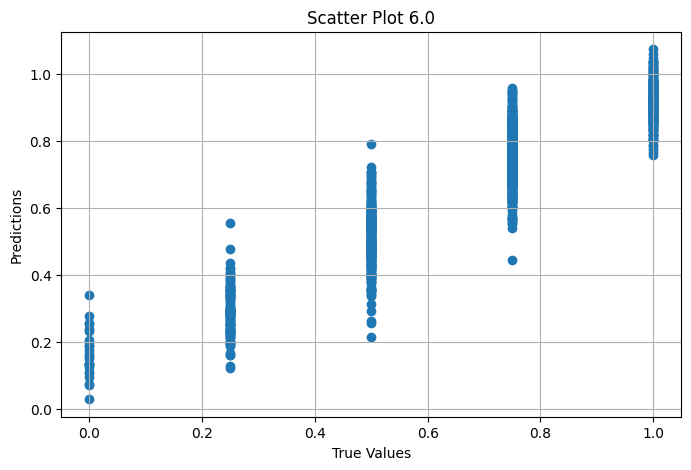

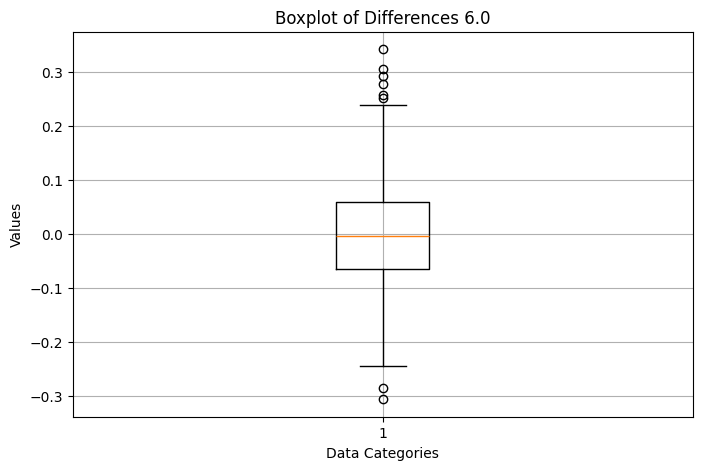

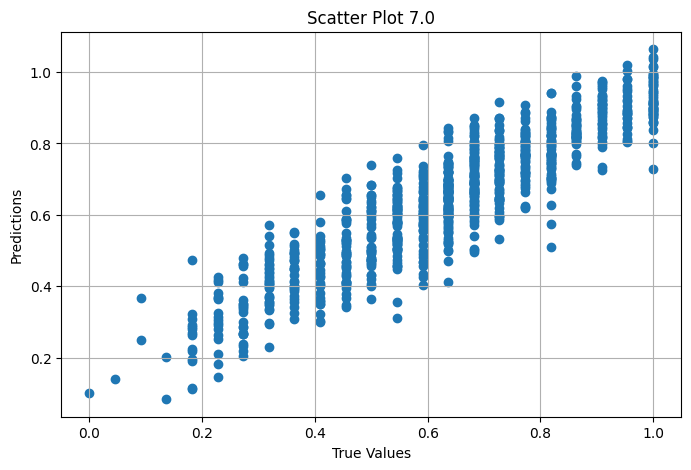

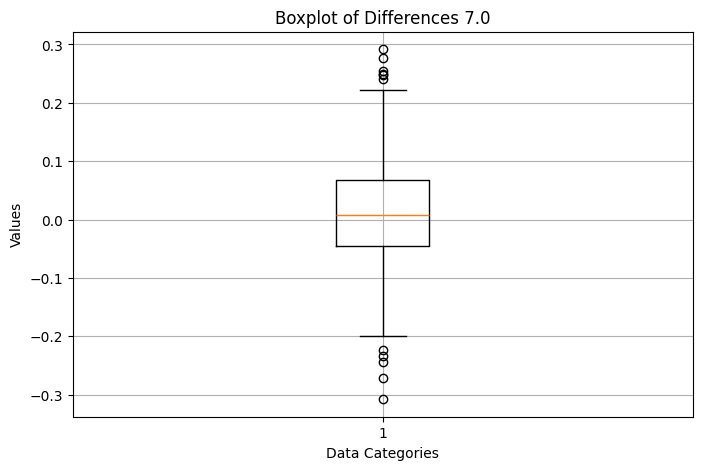

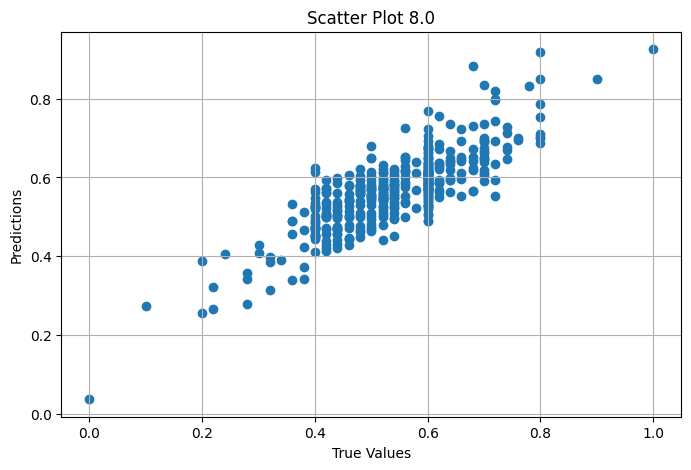

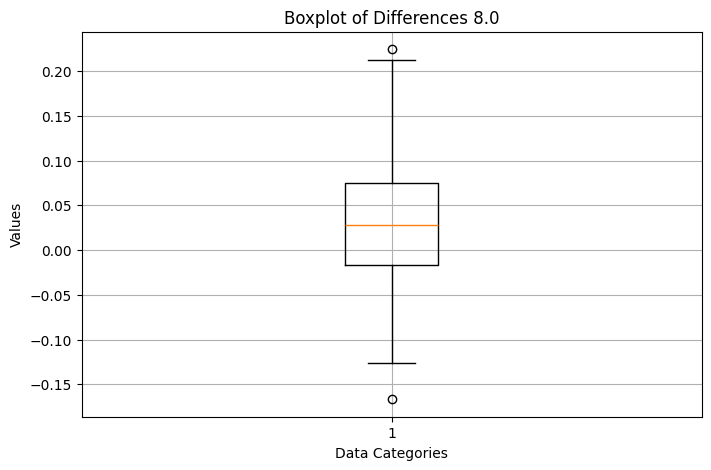

Correlation for Essay Topic 1.0:
0.89 

Correlation for Essay Topic 2.0:
0.84 

Correlation for Essay Topic 3.0:
0.88 

Correlation for Essay Topic 4.0:
0.94 

Correlation for Essay Topic 5.0:
0.93 

Correlation for Essay Topic 6.0:
0.93 

Correlation for Essay Topic 7.0:
0.91 

Correlation for Essay Topic 8.0:
0.83 

Mean for Essay Topic 1.0:
0.01 

Mean for Essay Topic 2.0:
0.01 

Mean for Essay Topic 3.0:
-0.0 

Mean for Essay Topic 4.0:
0.01 

Mean for Essay Topic 5.0:
0.0 

Mean for Essay Topic 6.0:
-0.0 

Mean for Essay Topic 7.0:
0.01 

Mean for Essay Topic 8.0:
0.03 



In [ ]:
# Find unique groups
groups = np.unique(y_train[:, 0])

# Dictionary to hold confusion matrices and means of the differences
confusion_matrices = {}
means_differences = {}

for group in groups:
    # Filter rows for the current group
    group_data = y_train[y_train[:, 0] == group]

    # True values are in the second column, predictions in the third
    true_values = group_data[:, 1]
    predictions = group_data[:, 2]
    differences = predictions - true_values

    # Compute the confusion matrix for the current group
    correlation, _ = pearsonr(true_values, predictions)

    # Store the confusion matrix using the group as the key
    confusion_matrices[group] = correlation
    means_differences[group] = np.mean(differences)

    # Scatter Plot
    plt.figure(figsize=(8, 5))  # Set the figure size
    plt.scatter(true_values, predictions)  # Create a scatter plot
    plt.title("Scatter Plot " + str(group))  # Title of the plot
    plt.xlabel("True Values")  # X-axis label
    plt.ylabel("Predictions")  # Y-axis label
    plt.grid(True)  # Show grid
    plt.show()

    # Boxplot
    plt.figure(figsize=(8, 5))  # Set the figure size for the boxplot
    plt.boxplot(differences)  # Create the boxplot from the DataFrame
    plt.title("Boxplot of Differences " + str(group))  # Title of the plot
    plt.xlabel("Data Categories")  # X-axis label (adjust as needed)
    plt.ylabel("Values")  # Y-axis label
    plt.grid(True)  # Show grid
    plt.show()  # Display the plot

# Display the confusion matrices
for group, cm in confusion_matrices.items():
    print(f"Correlation for Essay Topic {group}:")
    print(np.round(cm, 2), "\n")

for group, meandiff in means_differences.items():
    print(f"Mean for Essay Topic {group}:")
    print(np.round(meandiff, 2), "\n")

Validation Data:

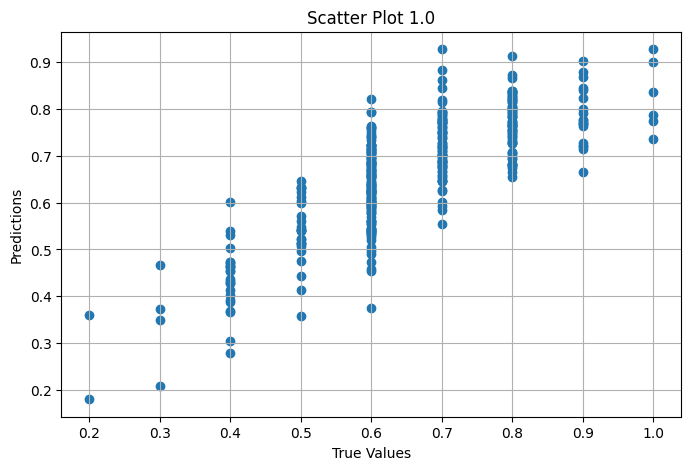

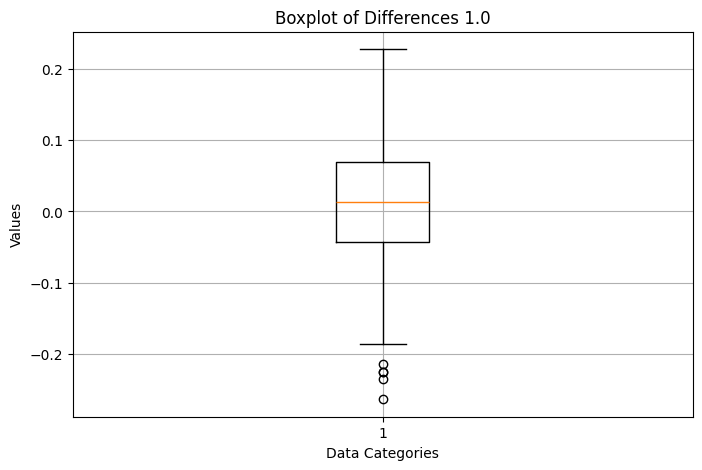

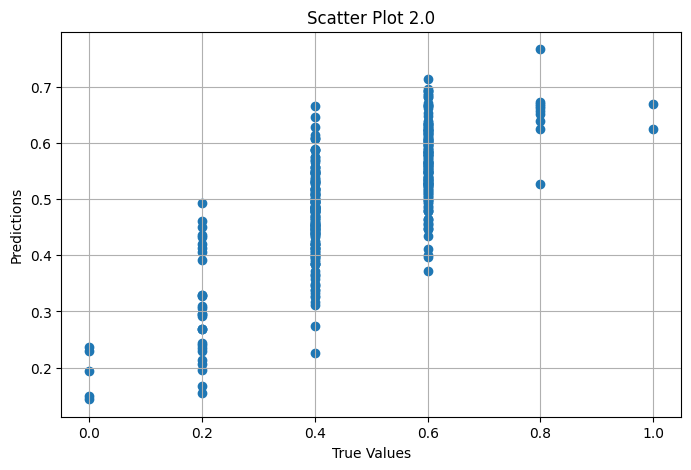

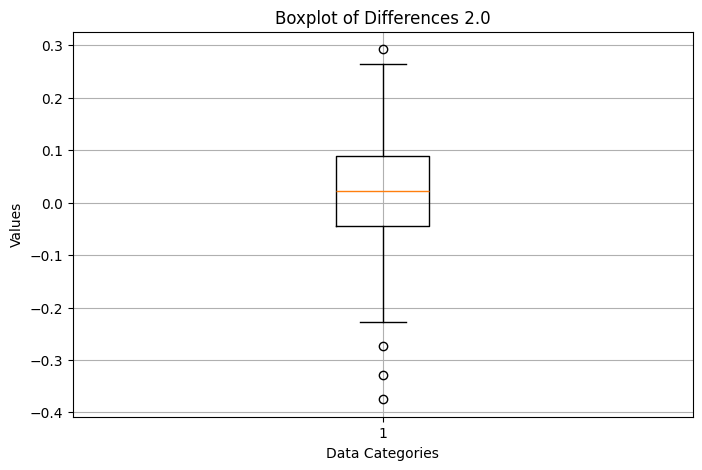

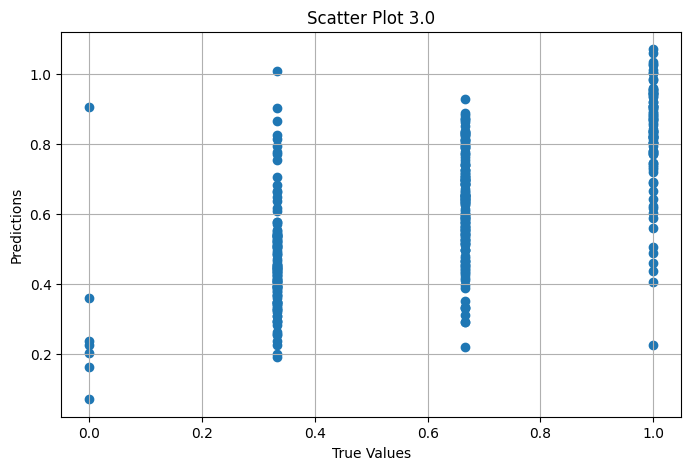

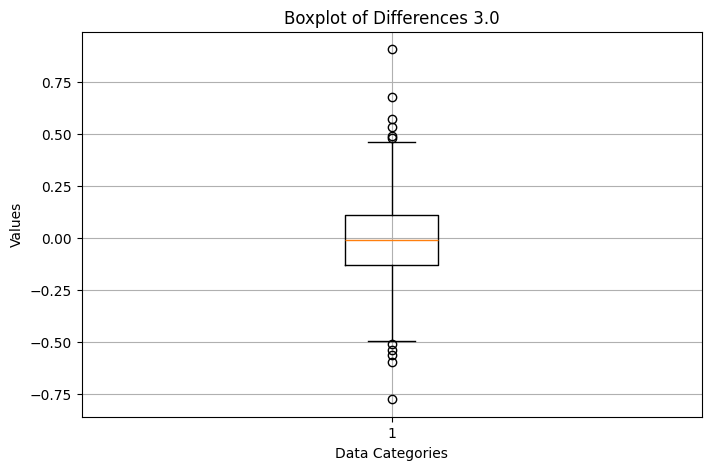

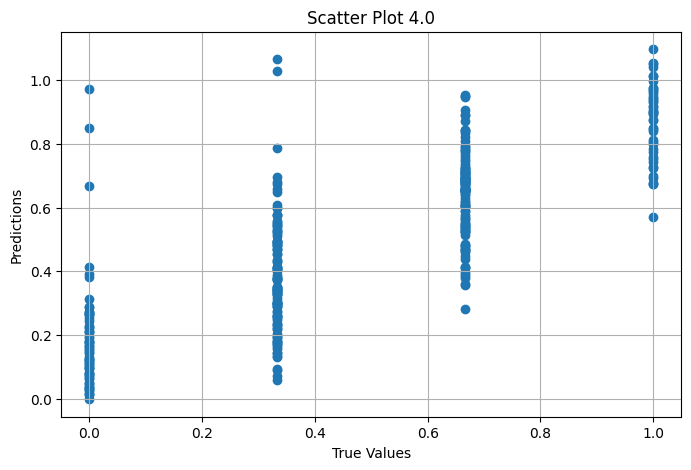

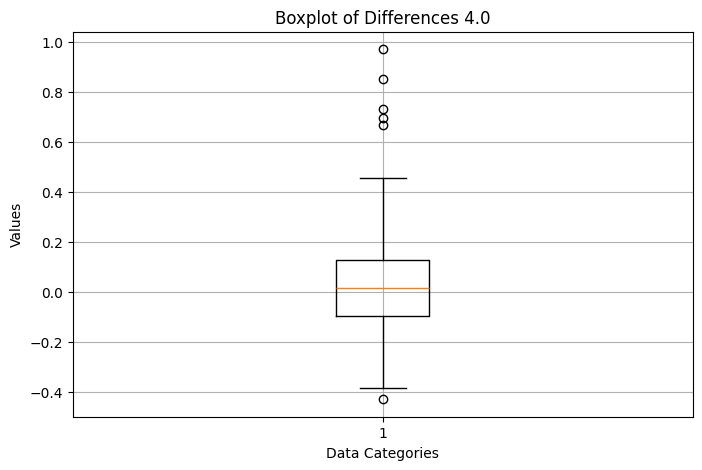

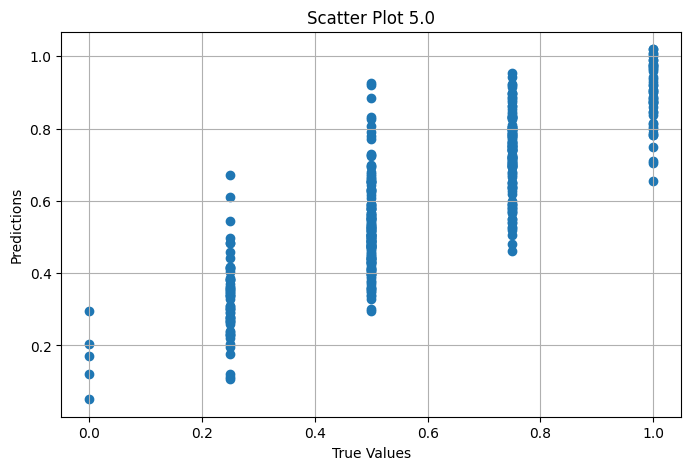

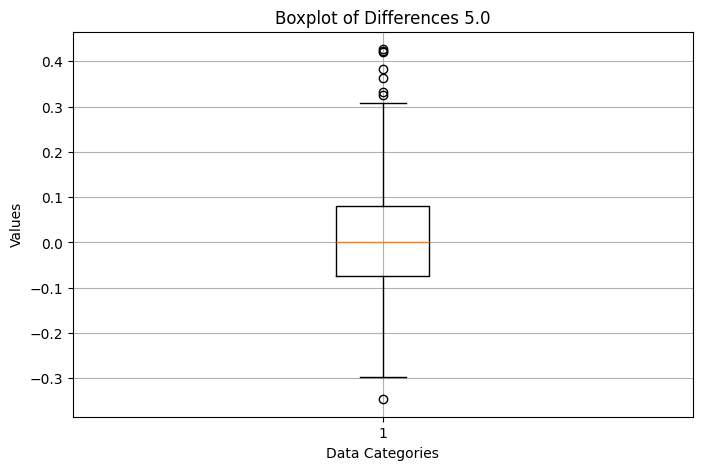

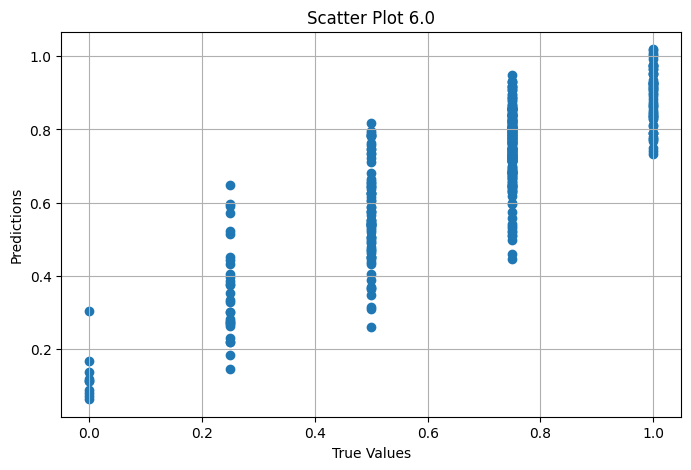

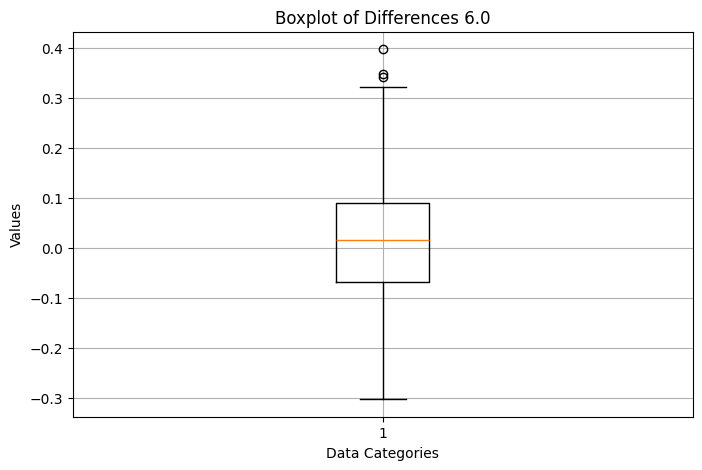

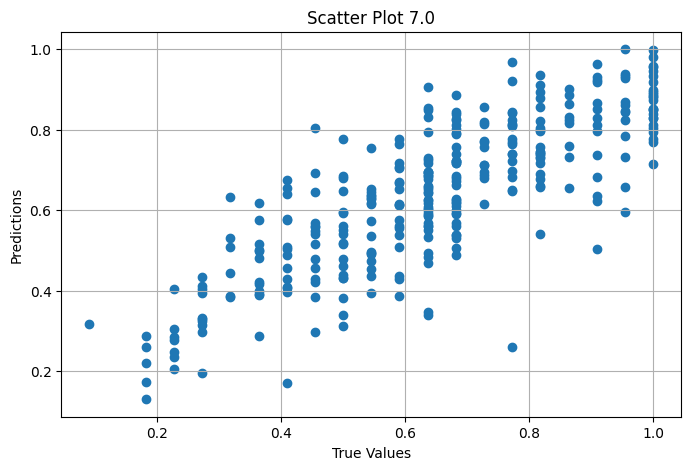

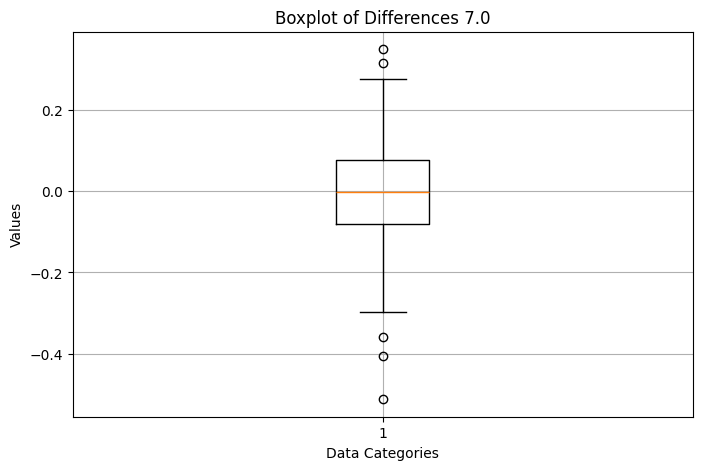

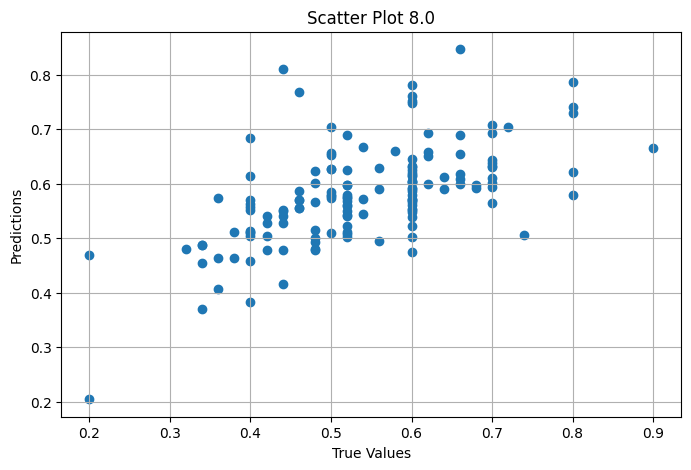

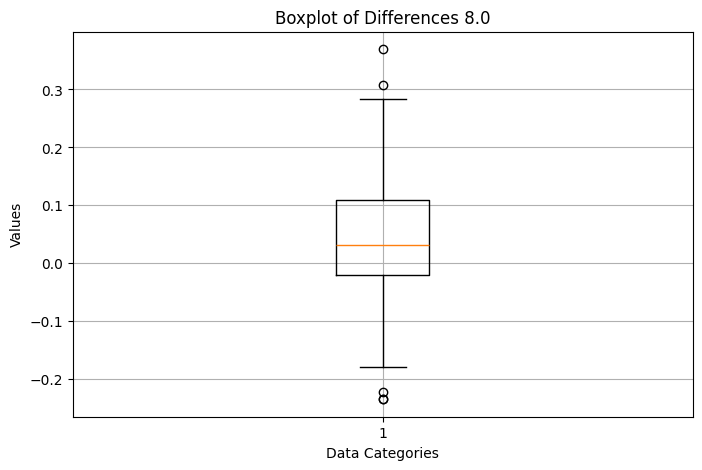

Correlation for Essay Topic 1.0:
0.8 

Correlation for Essay Topic 2.0:
0.74 

Correlation for Essay Topic 3.0:
0.66 

Correlation for Essay Topic 4.0:
0.81 

Correlation for Essay Topic 5.0:
0.84 

Correlation for Essay Topic 6.0:
0.84 

Correlation for Essay Topic 7.0:
0.81 

Correlation for Essay Topic 8.0:
0.59 

Mean for Essay Topic 1.0:
0.01 

Mean for Essay Topic 2.0:
0.02 

Mean for Essay Topic 3.0:
-0.01 

Mean for Essay Topic 4.0:
0.02 

Mean for Essay Topic 5.0:
0.01 

Mean for Essay Topic 6.0:
0.01 

Mean for Essay Topic 7.0:
-0.01 

Mean for Essay Topic 8.0:
0.04 



In [ ]:
# Find unique groups
groups = np.unique(y_valid[:, 0])

# Dictionary to hold confusion matrices and means of the differences
confusion_matrices = {}
means_differences = {}

for group in groups:
    # Filter rows for the current group
    group_data = y_valid[y_valid[:, 0] == group]

    # True values are in the second column, predictions in the third
    true_values = group_data[:, 1]
    predictions = group_data[:, 2]
    differences = predictions - true_values

    # Compute the confusion matrix for the current group
    correlation, _ = pearsonr(true_values, predictions)

    # Store the confusion matrix using the group as the key
    confusion_matrices[group] = correlation
    means_differences[group] = np.mean(differences)

    # Scatter Plot
    plt.figure(figsize=(8, 5))  # Set the figure size
    plt.scatter(true_values, predictions)  # Create a scatter plot
    plt.title("Scatter Plot " + str(group))  # Title of the plot
    plt.xlabel("True Values")  # X-axis label
    plt.ylabel("Predictions")  # Y-axis label
    plt.grid(True)  # Show grid
    plt.show()

    # Boxplot
    plt.figure(figsize=(8, 5))  # Set the figure size for the boxplot
    plt.boxplot(differences)  # Create the boxplot from the DataFrame
    plt.title("Boxplot of Differences " + str(group))  # Title of the plot
    plt.xlabel("Data Categories")  # X-axis label (adjust as needed)
    plt.ylabel("Values")  # Y-axis label
    plt.grid(True)  # Show grid
    plt.show()  # Display the plot

# Display the confusion matrices
for group, cm in confusion_matrices.items():
    print(f"Correlation for Essay Topic {group}:")
    print(np.round(cm, 2), "\n")

for group, meandiff in means_differences.items():
    print(f"Mean for Essay Topic {group}:")
    print(np.round(meandiff, 2), "\n")

Test Data:

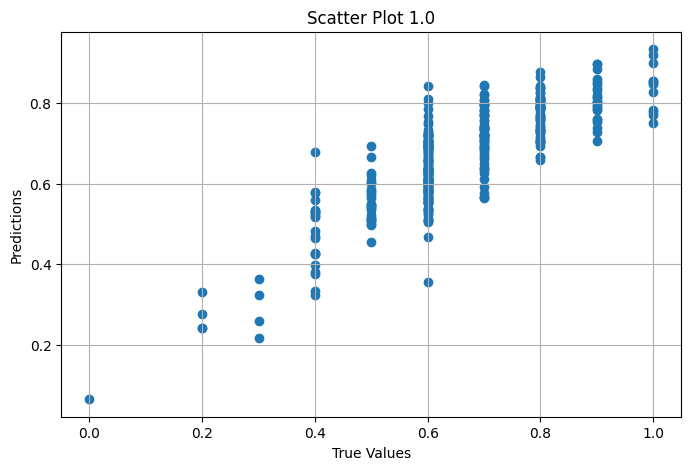

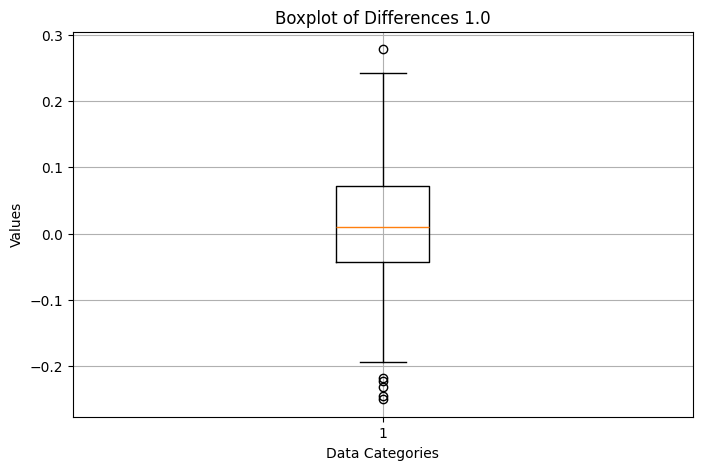

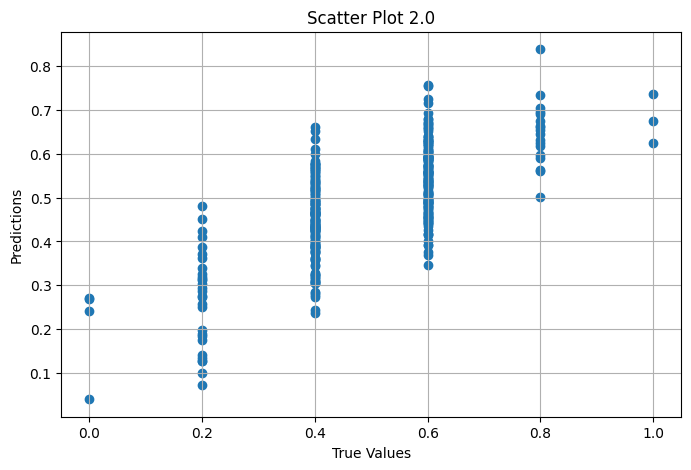

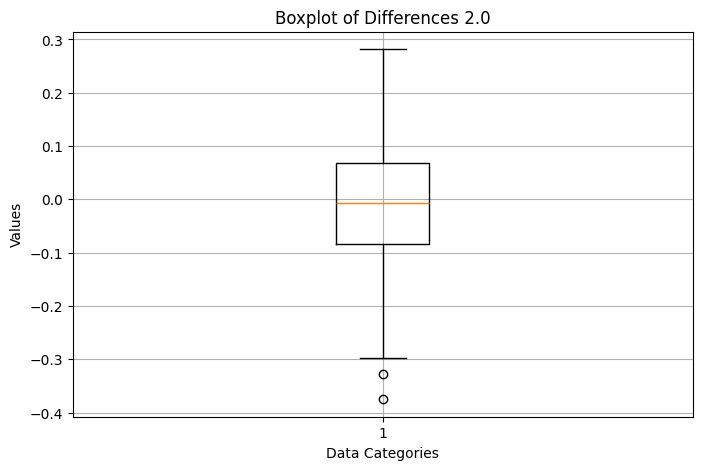

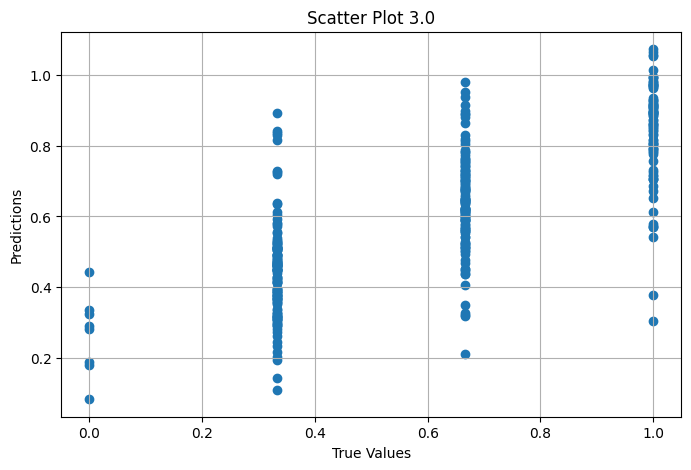

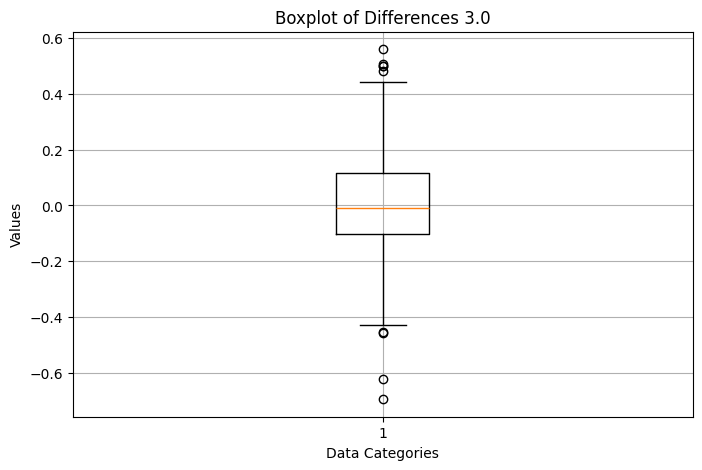

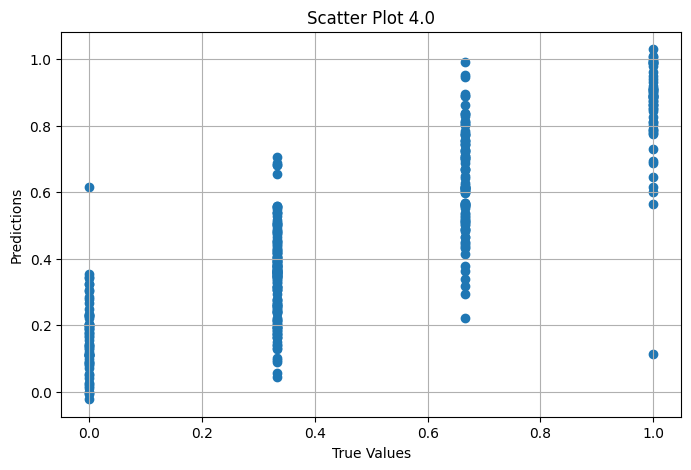

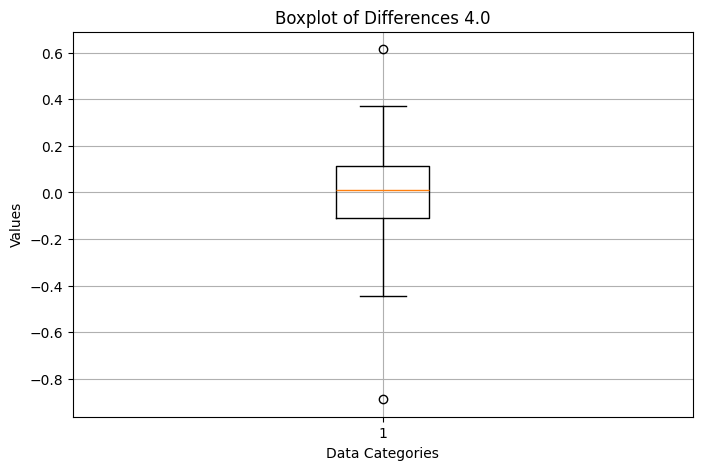

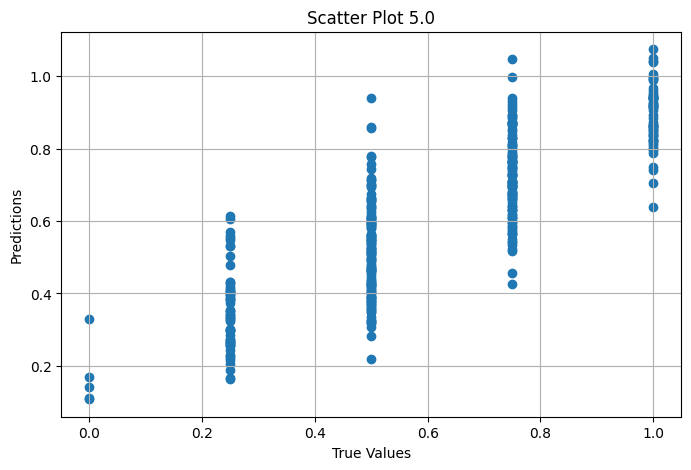

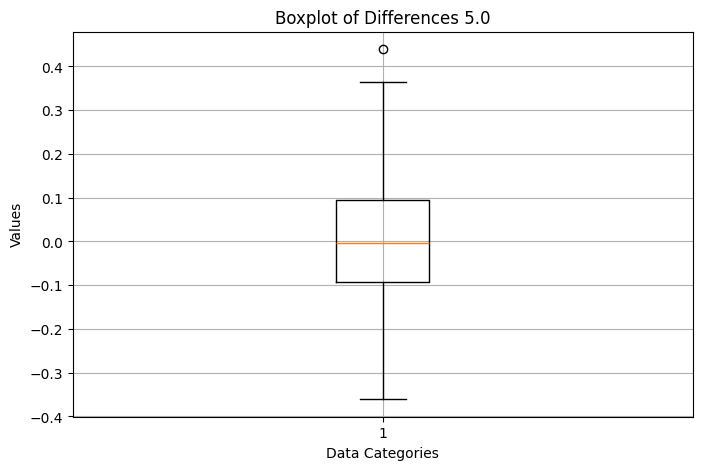

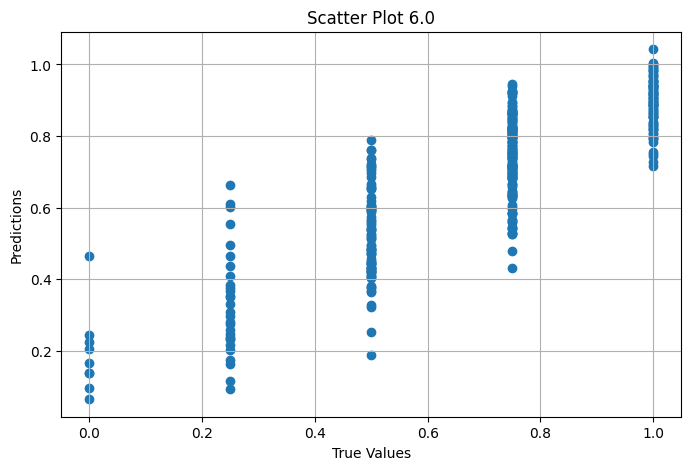

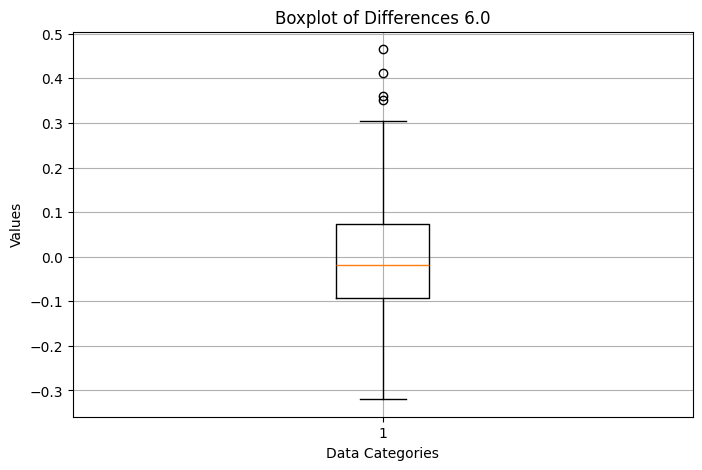

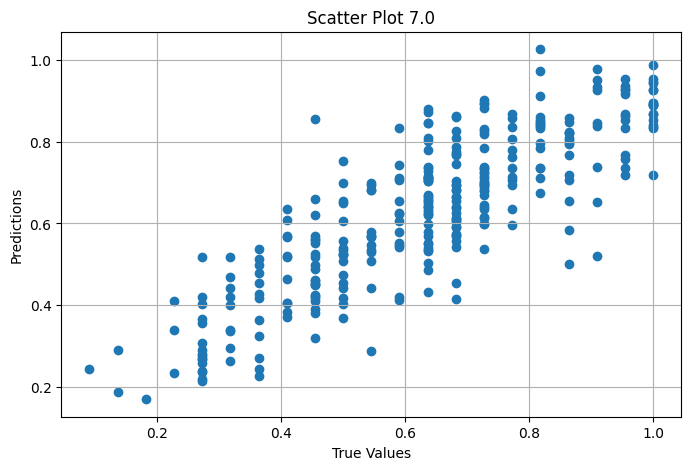

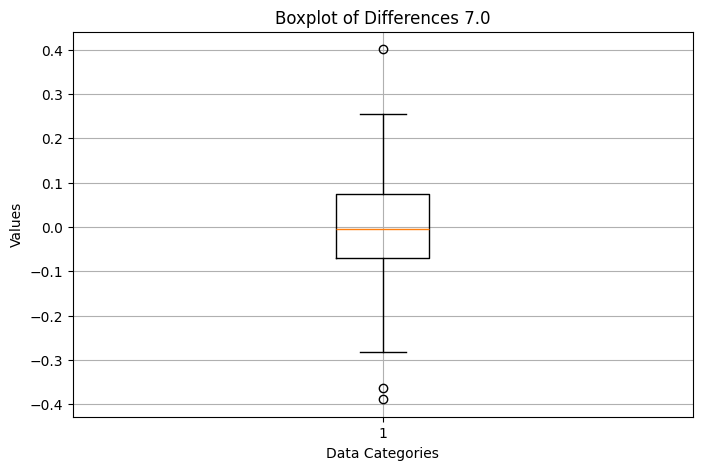

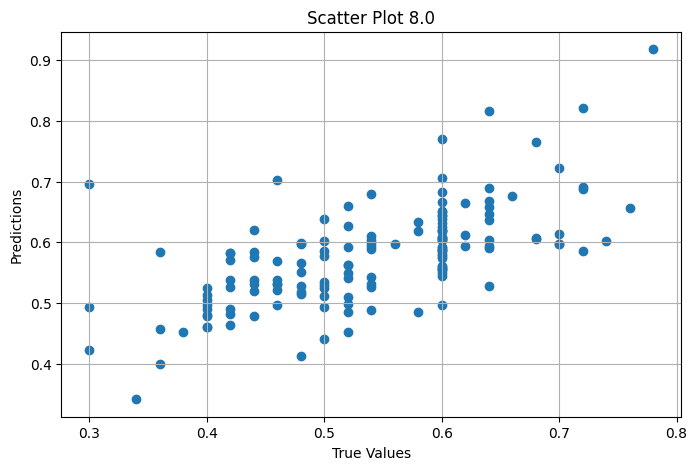

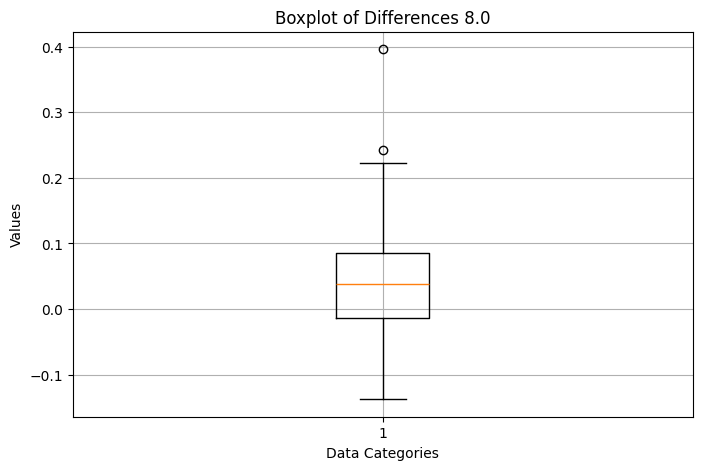

Correlation for Essay Topic 1.0:
0.84 

Correlation for Essay Topic 2.0:
0.71 

Correlation for Essay Topic 3.0:
0.77 

Correlation for Essay Topic 4.0:
0.85 

Correlation for Essay Topic 5.0:
0.84 

Correlation for Essay Topic 6.0:
0.86 

Correlation for Essay Topic 7.0:
0.84 

Correlation for Essay Topic 8.0:
0.65 

Mean for Essay Topic 1.0:
0.01 

Mean for Essay Topic 2.0:
-0.0 

Mean for Essay Topic 3.0:
-0.0 

Mean for Essay Topic 4.0:
0.0 

Mean for Essay Topic 5.0:
0.0 

Mean for Essay Topic 6.0:
-0.01 

Mean for Essay Topic 7.0:
-0.0 

Mean for Essay Topic 8.0:
0.04 



In [ ]:
# Find unique groups
groups = np.unique(y_test[:, 0])

# Dictionary to hold confusion matrices and means of the differences
confusion_matrices = {}
means_differences = {}

for group in groups:
    # Filter rows for the current group
    group_data = y_test[y_test[:, 0] == group]

    # True values are in the second column, predictions in the third
    true_values = group_data[:, 1]
    predictions = group_data[:, 2]
    differences = predictions - true_values

    # Compute the confusion matrix for the current group
    correlation, _ = pearsonr(true_values, predictions)

    # Store the confusion matrix using the group as the key
    confusion_matrices[group] = correlation
    means_differences[group] = np.mean(differences)

    # Scatter Plot
    plt.figure(figsize=(8, 5))  # Set the figure size
    plt.scatter(true_values, predictions)  # Create a scatter plot
    plt.title("Scatter Plot " + str(group))  # Title of the plot
    plt.xlabel("True Values")  # X-axis label
    plt.ylabel("Predictions")  # Y-axis label
    plt.grid(True)  # Show grid
    plt.show()

    # Boxplot
    plt.figure(figsize=(8, 5))  # Set the figure size for the boxplot
    plt.boxplot(differences)  # Create the boxplot from the DataFrame
    plt.title("Boxplot of Differences " + str(group))  # Title of the plot
    plt.xlabel("Data Categories")  # X-axis label (adjust as needed)
    plt.ylabel("Values")  # Y-axis label
    plt.grid(True)  # Show grid
    plt.show()  # Display the plot

# Display the confusion matrices
for group, cm in confusion_matrices.items():
    print(f"Correlation for Essay Topic {group}:")
    print(np.round(cm, 2), "\n")

for group, meandiff in means_differences.items():
    print(f"Mean for Essay Topic {group}:")
    print(np.round(meandiff, 2), "\n")